
## Predicting Project Approval
---
> The DonorsChoose.org portal receives a staggering number of classroom project proposals (hundreds of thousands!) each year. Manually reviewing each one by a large volunteer force is becoming unsustainable.

The **objective** is to streamline the screening process and ensure all proposals receive a fair and consistent review. This will help in freeing up volunteer time to focus on proposals that require more hands-on guidance.


---




***This is where you come in!***  

**Problem Statement ->** Your goal is to develop a system that predicts project approval based on the teacher's description, along with other details about the project, teacher, and school.


**Steps**
1. Data Collection, Exploration and Preprocessing
2. EDA
3. Pre-Modelling Data Preparation
4. Model Building
5. Model Evaluation
6. Summary



---



## Data Collection, Exploration and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle

from tqdm import tqdm
import os
import zipfile

In [2]:
# ## 1. Data Collection

# ### Import Libraries
# Import the necessary libraries for loading data and data manipulation
import os
import gdown
import zipfile
import pandas as pd
import numpy as np

# ### Download Dataset
# The dataset can be downloaded using the provided code. The data will be extracted into a specified directory.
dataset_url = "https://drive.google.com/uc?export=download&id=1KrnpfYRKVxGDnj-R2VZmNscEkR1zr2-4"
dataset_path = "./dataset/donors_choose" # the dataset will be downloaded in this folder
zip_file_path = os.path.join(dataset_path, "donors_choose_dataset.zip")

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
if not os.path.exists(zip_file_path):
    gdown.download(dataset_url, zip_file_path, quiet=False)
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(dataset_path)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1KrnpfYRKVxGDnj-R2VZmNscEkR1zr2-4
From (redirected): https://drive.google.com/uc?export=download&id=1KrnpfYRKVxGDnj-R2VZmNscEkR1zr2-4&confirm=t&uuid=28dabcca-5aba-4e80-82ec-b56667cd93ed
To: /content/dataset/donors_choose/donors_choose_dataset.zip
100%|██████████| 111M/111M [00:04<00:00, 23.4MB/s]


---


### **Accessing the dataset**
To access the dataset, open the **Files** section by clicking the folder icon on the left pane; it should display the label 'Files' when you hover over it.

> Within the Files section, you will find a folder named dataset. Inside this folder, there is another folder called *donors_choose*.

> Within the donors_choose folder, you will find two CSV files:
1. train_data.csv
2. resources.csv

These two CSV files make up the dataset.

In [3]:
# First, load the two CSV files into separate dataframes using pandas.
# Type your code below.

train_data = pd.read_csv('./dataset/donors_choose/train_data.csv')
resources_data = pd.read_csv('./dataset/donors_choose/resources.csv')

Provide a summary of each dataframe, including its size, features, target variable, and data types.

In [4]:
# View the top few rows of both the dataframe
# Type the code here

train_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


In [5]:
resources_data.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [6]:
# Check the shape

train_data.shape

(109248, 17)

#### **Understanding the Dataset**
We have included some additional information below to help you understand better.

The `train.csv` data set provided by DonorsChoose contains the following features -->

Feature | Description
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul>
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul>
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul>
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup>
**`project_essay_3`**    | Third application essay<sup>*</sup>
**`project_essay_4`**    | Fourth application essay<sup>*</sup>
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2`



---

**Notes on the Essay Data**

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_4:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>



---


Additionally, the `resources.csv` data set provides more data about the resources required for each project.

Feature | Description
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required (each unit). **Example:** `9.95`   

---


#### **To predict (Output/Target Feature)**
The `train.csv` contains the following column (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.


In [7]:
## Using appropriate methods check the datatypes and null values in the different columns of train_df

print(train_data.isna().sum())
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 17 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   Unnamed: 0                                    109248 non-null  int64 
 1   id                                            109248 non-null  object
 2   teacher_id                                    109248 non-null  object
 3   teacher_prefix                                109245 non-null  object
 4   school_state                                  109248 non-null  object
 5   project_submitted_datetime                    109248 non-null  object
 6   project_grade_category                        109248 non-null  object
 7   project_subject_categories                    109248 non-null  object
 8   project_subject_subcategories                 109248 non-null  object
 9   project_title                                 109248 non-nu

In [8]:
## Check the shape of train_df

train_data.shape

(109248, 17)

In [9]:
## Using appropriate methods check the datatypes and null values in the different columns of resources_df

resources_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541272 entries, 0 to 1541271
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           1541272 non-null  object 
 1   description  1540980 non-null  object 
 2   quantity     1541272 non-null  int64  
 3   price        1541272 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 47.0+ MB


In [10]:
## Check the shape of resources_df

resources_data.shape

(1541272, 4)

In [11]:
## Check the data consistency between the train_df and resources_df dataframes
## Check if both the dataframes contain same or different application ids

len(train_data.id.unique()) # 109248

109248

In [12]:
len(resources_data.id.unique()) # 260115

260115

**Observations**

*Document your observations for the analysis done till now around missing values, data types and data consistency*

- *train_data:*

1.   More than 95% of values in `project_essay_3` & `project_essay_4`
columns are null. Reduction in no. of essays from 4 to 2 effective May 17, 2016 is the reason for the null data in these columns.
2.   The column `teacher_prefix` has 3 null rows.
3.   Rest of the data seems to be good.


- *resources_data:*

1.   There are 292 rows with null data in the column `description`.  
2.   After further analysis I'll confirm if this column is a strong predictor. If not, we can drop the column.


- There is a mismatch in the no. of unique `id` values between the `train_data` and the `resources_data`. We may have received a partial data in `train_data`. We'll need to only use the `resources_data` entries that have the matching project ids in `train_data`.

#### Creating the Master Dataframe - project_data

Before proceeding with doing the data sanity checks as documented above, you need to combine the two dataframes train_df into a single dataframe by merging them on the `project-ids`

> **Note:** Each line in the resources.csv file represents a resource required by a project. Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project. Also the `price` column denotes the price per unit of the item denoted by the `description` column

##### Perform these steps to complete this task:
- Using the `resources_df`,  create a new dataframe that contains the project_id, total quantity of resources for each project and total amount required for all the resources for that project.
- Merge this new dataframe with the `train_df` dataframe. Peform an inner join.
- Name this dataframe as `project_data`

In [13]:
## Write your code here to generate the new dataframe from resources_df
## Hint - You might have to create a new column and perform a groupby

# add a new column to store computed amount value
resources_data['amount'] = resources_data['price'] * resources_data['quantity']

In [14]:
# Create a new DF for resources with aggregated amounts & quanity by id

resources_agg = resources_data.groupby('id').agg({
    'amount': 'sum',
    'quantity': 'sum'
}).reset_index()

In [15]:
## Write the code to perform the merge operation
## Name this new dataframe as project_data

# Merge the aggregated data in the original dataframe by the id value. Drop 1st column.
project_data = pd.merge(train_data, resources_agg, on='id', how='inner')
project_data.drop(['Unnamed: 0'], axis = 'columns', inplace=True)

In [16]:
project_data.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,amount,quantity
0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,596.36,23
1,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.00,1
2,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,686.68,22
3,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,431.90,4
4,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,143.96,4


***Checklist***

Before proceeding further, check
- the shape of `project_data`. There should be around 100k rows and 17-18 columns
- the datatypes of all the variables, most should be object datatype with a few numeric columns
- the columns containing null values, should be around 3 columns

In [17]:
## Write the code to check the above

project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 18 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            109248 non-null  object 
 1   teacher_id                                    109248 non-null  object 
 2   teacher_prefix                                109245 non-null  object 
 3   school_state                                  109248 non-null  object 
 4   project_submitted_datetime                    109248 non-null  object 
 5   project_grade_category                        109248 non-null  object 
 6   project_subject_categories                    109248 non-null  object 
 7   project_subject_subcategories                 109248 non-null  object 
 8   project_title                                 109248 non-null  object 
 9   project_essay_1                               10

Once the checks are done, proceed further

#### Missing Value Treatment

**project_essay columns**

Some of the `project_essay_*` columns contain null values. Revisit the `Understanding the Data` section to understand why this is so

In [18]:
## Identify a suitable strategy to treat the missing values
## Hint - One possible strategy could be to create a combined column of all the essay columns
## And then remove the original project_essay_* columns

# Concatenate project essay columns into a single value
project_data["project_essay"] = project_data[["project_essay_1", "project_essay_2", "project_essay_3", "project_essay_4"]] \
  .astype(str).agg(" ".join, axis=1)
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 19 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            109248 non-null  object 
 1   teacher_id                                    109248 non-null  object 
 2   teacher_prefix                                109245 non-null  object 
 3   school_state                                  109248 non-null  object 
 4   project_submitted_datetime                    109248 non-null  object 
 5   project_grade_category                        109248 non-null  object 
 6   project_subject_categories                    109248 non-null  object 
 7   project_subject_subcategories                 109248 non-null  object 
 8   project_title                                 109248 non-null  object 
 9   project_essay_1                               10

In [19]:
# Drop the individual project essay columns and keep the concatenated value instead
project_data.drop(["project_essay_1", "project_essay_2", "project_essay_3", "project_essay_4"], axis = 'columns', inplace=True)
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            109248 non-null  object 
 1   teacher_id                                    109248 non-null  object 
 2   teacher_prefix                                109245 non-null  object 
 3   school_state                                  109248 non-null  object 
 4   project_submitted_datetime                    109248 non-null  object 
 5   project_grade_category                        109248 non-null  object 
 6   project_subject_categories                    109248 non-null  object 
 7   project_subject_subcategories                 109248 non-null  object 
 8   project_title                                 109248 non-null  object 
 9   project_resource_summary                      10

**teacher_prefix** column

`teacher_prefix` has a few missing values. Develop a suitable strategy to fix this

In [20]:
## Write your code here

# Dheck the distribution of the current values
project_data['teacher_prefix'].value_counts()

,count
teacher_prefix,
Mrs.,57269
Ms.,38955
Mr.,10648
Teacher,2360
Dr.,13


In [21]:
# Check of any null values in the prefix column
project_data[project_data['teacher_prefix'].isna()]

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,amount,quantity,project_essay
7820,p180947,834f75f1b5e24bd10abe9c3dbf7ba12f,NaN,CA,2016-11-04 00:15:45,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",1:7 Increasing Tech to Decrease Achievement Gaps,My students need a classroom laptop that is ju...,1,1,910.87,2,The children at Anna Yates Elementary school a...
30368,p002730,339bd5a9e445d68a74d65b99cd325397,NaN,SC,2016-05-09 09:38:40,Grades 9-12,Literacy & Language,Literature & Writing,iPads for STEM Stations,My students need 5 iPads for STEM stations.,0,1,1389.34,16,"Within the next 20 years, every job will invol..."
57654,p197901,e4be6aaaa887d4202df2b647fbfc82bb,NaN,PA,2016-06-03 10:15:05,Grades 3-5,"Literacy & Language, Math & Science","Literacy, Mathematics",Document Camera,My students need a Smart Document Camera to en...,0,1,145.29,2,Students at Robertsdale Elementary live in a l...


In [22]:
# find most freq prefix and apply to the 3 rows missing the prefix value
freq_prefix = project_data['teacher_prefix'].mode()[0] # Mrs. is the most common prefix
project_data['teacher_prefix'].fillna(freq_prefix, inplace=True)

***Checklist***

Before proceeding further, check
- null values in the dataframe. There should be none
- first few rows of the dataframe for inspection purpose

In [23]:
## Write your code here
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            109248 non-null  object 
 1   teacher_id                                    109248 non-null  object 
 2   teacher_prefix                                109248 non-null  object 
 3   school_state                                  109248 non-null  object 
 4   project_submitted_datetime                    109248 non-null  object 
 5   project_grade_category                        109248 non-null  object 
 6   project_subject_categories                    109248 non-null  object 
 7   project_subject_subcategories                 109248 non-null  object 
 8   project_title                                 109248 non-null  object 
 9   project_resource_summary                      10

With this the first section of the code notebook is now completed. Now, let's proceed to the next section on Exploratory Data Analysis or EDA.

## EDA (Exploratory Data Analysis)

For this section, you have to compute various univariate and bivariate analysis for the different columns of interest in the `project_data` dataframe.
You have the freedom to do as much analysis as possible. However, for the sake of brevity, we are suggesting the following tasks

**EDA-1**: What is the percentage (fraction) and number of projects that are approved versus not approved? Create a visualization of the results.

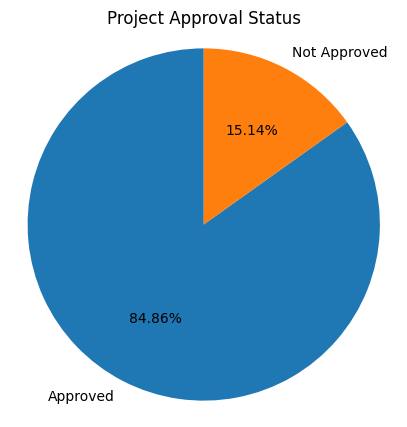

In [24]:
#Write your code here
# find counts of approved vs not approved projects

status_map = {1: 'Approved', 0: 'Not Approved'}
proj_status_counts = project_data['project_is_approved'].map(status_map).value_counts()
all_projects = project_data['project_is_approved'].count

# Plotting the distribution of project approval status on a pie chart
plt.figure(figsize=(5, 5))
plt.pie(proj_status_counts, labels=proj_status_counts.index, autopct='%1.2f%%', startangle=90)
plt.title('Project Approval Status')
plt.axis('equal')  # pie shows as circle
plt.show()

**EDA-2**: Analyse the approval rate per state. *You can also plot the approval rates for the top k states*.

Top 5 Entries by Approval Percentage:
CA: Total=15388.0: Percentage=85.81%
TX: Total=7396.0: Percentage=81.31%
NY: Total=7318.0: Percentage=85.97%
FL: Total=6185.0: Percentage=83.17%
NC: Total=5091.0: Percentage=85.50%


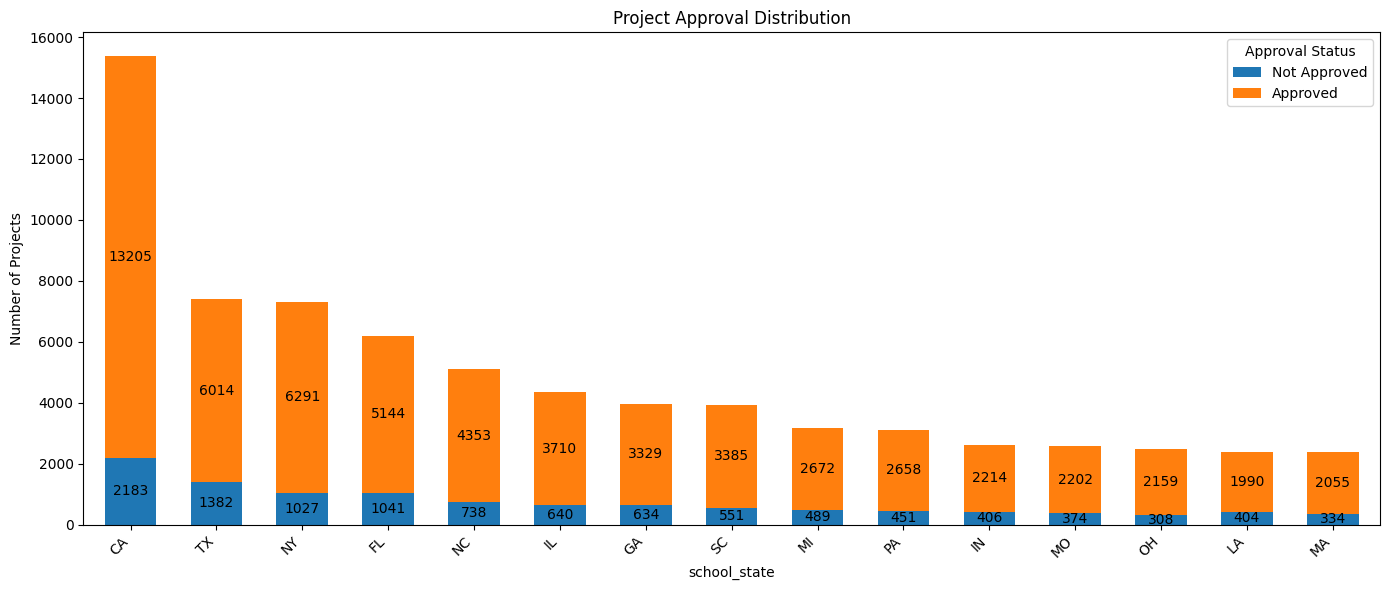

In [25]:
#Write your code here

def plot_stack_bar_charts(by_column, k=20):

  pivot_data = project_data.pivot_table(
      index=by_column,
      columns='project_is_approved',
      aggfunc='size',
      fill_value=0
  )

  # Rename the columns for clarity
  pivot_data.columns = ['Not Approved', 'Approved']

  # Calculate total projects for each entity
  pivot_data['Total'] = pivot_data['Approved'] + pivot_data['Not Approved']
  pivot_data['Approval Percentage'] = pivot_data['Approved'] / (pivot_data['Approved'] + pivot_data['Not Approved']) * 100
  pivot_data['Approval Percentage'] = round(pivot_data['Approval Percentage'], 2)

  # Sort by total projects and select top k entities
  top_k_entities = pivot_data.sort_values('Total', ascending=False).head(k)

  # Print the top 5 entries with their approval percentages in descending order
  print("Top 5 Entries by Approval Percentage:")
  for entity, row in top_k_entities.head(5).iterrows():
    print(f"{entity}: Total={row['Total']}: Percentage={row['Approval Percentage']:.2f}%")

  # Sort by 'Approved' column for the final order (if needed)
  # top_k_entries = top_k_entries.sort_values('Approved', ascending=False)

  # Drop the 'Total' & 'Approval Percentage' columns as we don't need it for plotting
  top_k_entities = top_k_entities.drop(['Total', 'Approval Percentage'], axis=1)

  # Create the stacked bar plot
  ax = top_k_entities.plot(kind='bar', stacked=True, figsize=(14, 6), width=0.6)

  # Customize the plot
  plt.title(f'Project Approval Distribution')
  # plt.xlabel('State')
  plt.ylabel('Number of Projects')
  plt.legend(title='Approval Status')

  # Rotate x-axis labels for better readability
  plt.xticks(rotation=45, ha='right')

  # Add value labels on the bars
  for c in ax.containers:
      ax.bar_label(c, label_type='center')

  # Adjust layout to prevent cutting off labels
  plt.tight_layout()

  # Show the plot
  plt.show()



# invoke the function to show top K states, default = 20 states
plot_stack_bar_charts('school_state', 15) # show chart for 15 states


**EDA-3**: Analyse the approval rate per project_grade_category using stacked bar chart

Top 5 Entries by Approval Percentage:
Grades PreK-2: Total=44225.0: Percentage=84.88%
Grades 3-5: Total=37137.0: Percentage=85.44%
Grades 6-8: Total=16923.0: Percentage=84.25%
Grades 9-12: Total=10963.0: Percentage=83.76%


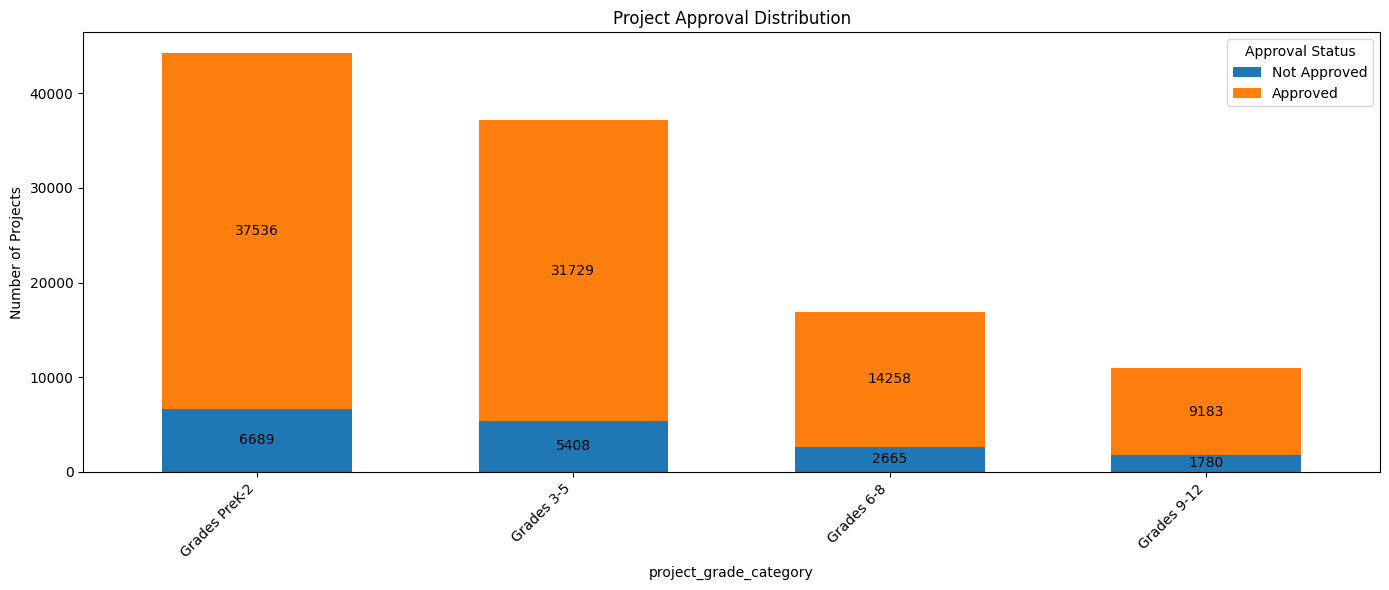

In [26]:
#Write your code here
plot_stack_bar_charts(by_column='project_grade_category', k=10)

**EDA-4**: Analyse the approval rate per project_subject_categories.
- Is the approval rate same for all categories?
- Do all categories have almost equal representation?
- Any skewness observed?

Top 5 Entries by Approval Percentage:
Literacy: Total=9486.0: Percentage=88.25%
Literacy, Mathematics: Total=8325.0: Percentage=87.21%
Literature & Writing, Mathematics: Total=5923.0: Percentage=86.78%
Literacy, Literature & Writing: Total=5571.0: Percentage=86.57%
Mathematics: Total=5379.0: Percentage=81.52%


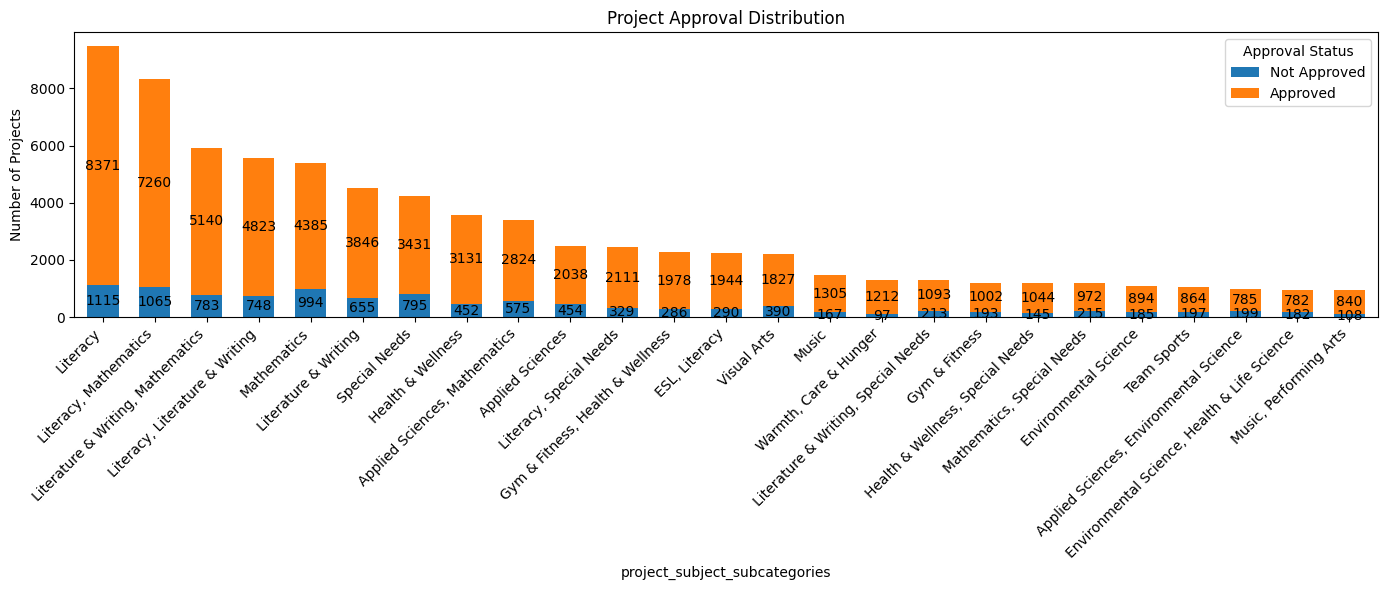

In [27]:
#Write your code here
plot_stack_bar_charts('project_subject_subcategories', 25)

# Findings:
# Literacy, Maths, Literature/Writing, Special Needs, Applied Science, Health/Fitness are the top categories with higher approval %

**EDA-5**: Is there any gender bias for approval?
  - Use the teacher_prefix column.

Top 5 Entries by Approval Percentage:
Mrs.: Total=57272.0: Percentage=85.56%
Ms.: Total=38955.0: Percentage=84.35%
Mr.: Total=10648.0: Percentage=84.15%
Teacher: Total=2360.0: Percentage=79.53%
Dr.: Total=13.0: Percentage=69.23%


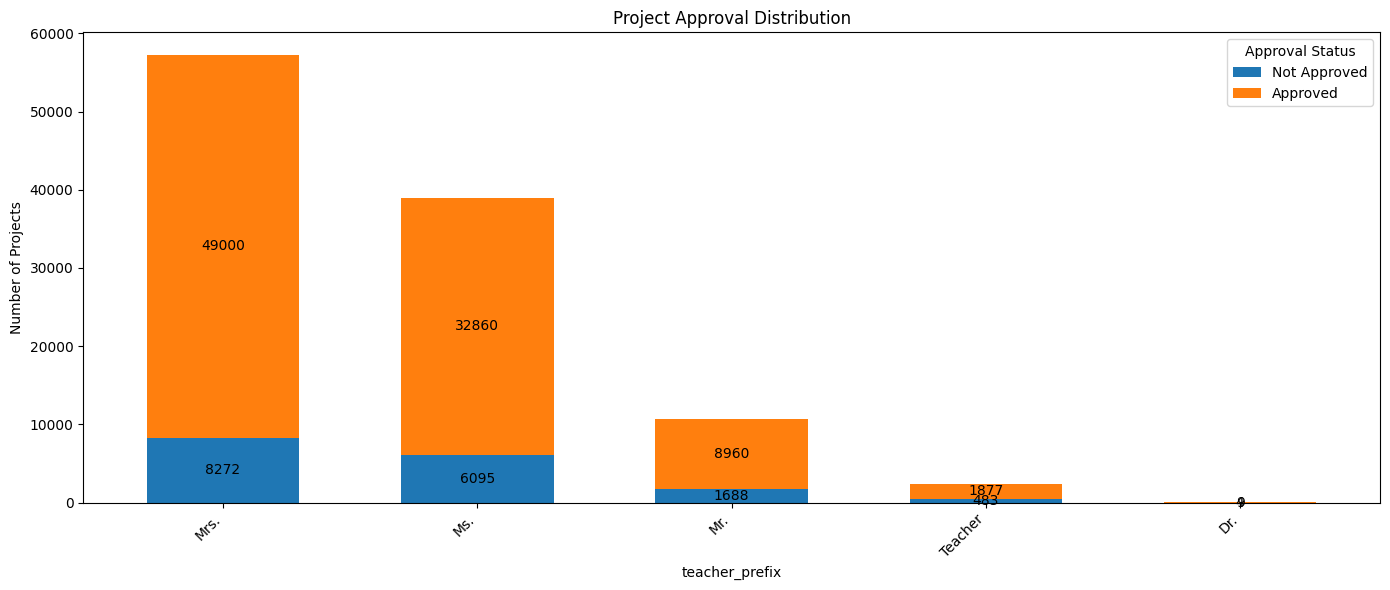

In [28]:
#Write your code here
plot_stack_bar_charts('teacher_prefix', 10)

# Findings:
# Gender bias definitely exists. Data shows skewnewss towards female teachers.

**EDA-6**: Check whether the approval rate depends on the amount and quantity of the resources?
- Provide descriptive statstics for approved & not-approved projects.
- with appropriate visualizations for a better understanding of the results

In [29]:
# Get stats on mean, medium, std deviation, distribution in different quartiles (Q1, Q2, Q3, Q4)
pivot_table = pd.pivot_table(project_data,
                             values='amount',
                             index='project_is_approved',
                             aggfunc=['mean', 'median', 'std'])

pivot_table.columns = ['Mean', 'Median', 'Std Dev']
print(pivot_table)

x_median_approved = pivot_table['Median'][1]
x_median_not_approved = pivot_table['Median'][0]

                           Mean  Median     Std Dev
project_is_approved                                
0                    590.922012  428.36  565.254646
1                    537.489913  391.44  543.081743


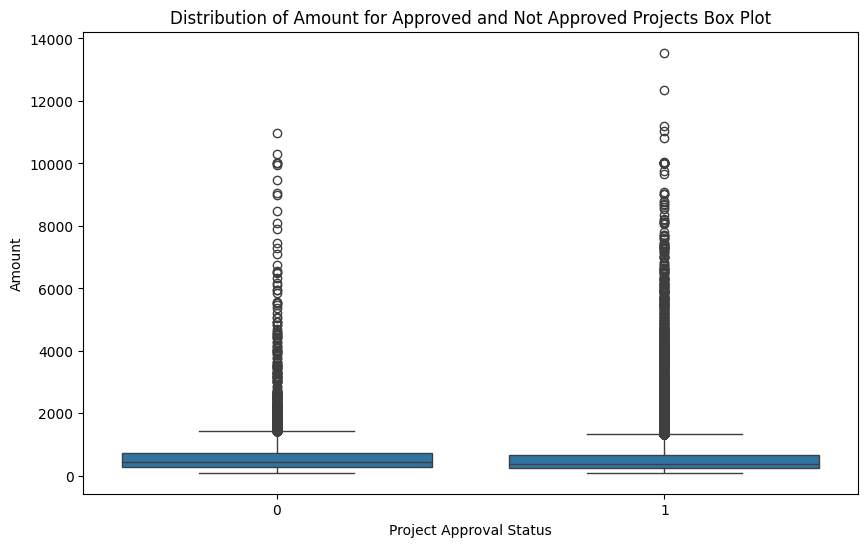

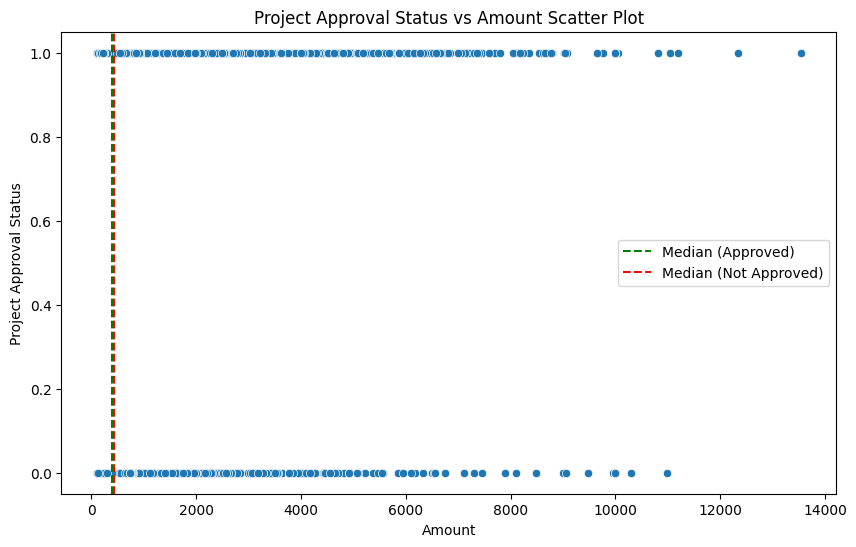

In [30]:
## Write code for additional analysis here
plt.figure(figsize=(10, 6))
sns.boxplot(x='project_is_approved', y='amount', data=project_data)
plt.title('Distribution of Amount for Approved and Not Approved Projects Box Plot')
plt.xlabel('Project Approval Status')
plt.ylabel('Amount')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='amount', y='project_is_approved', data=project_data)
plt.title('Project Approval Status vs Amount Scatter Plot')
plt.xlabel('Amount')
plt.ylabel('Project Approval Status')
plt.axvline(x=x_median_approved, color='g', linestyle='--', label='Median (Approved)')
plt.axvline(x=x_median_not_approved, color='r', linestyle='--', label='Median (Not Approved)')
plt.legend()
plt.show()


### Observations:
#### 1. Median amount for approved projects is `$391.44` while rejected  projects is `$428.36`
#### 2. The mean & median values indicate that there are some outliers for amount values for both the approved/rejected projects

**EDA-7**: Conduct further analysis to uncover patterns, anomalies, and relationships within the data.
- Summary statistics
- Distribution plots
- Correlation matrix (for numerical features)
- how approval rate changes across the different features

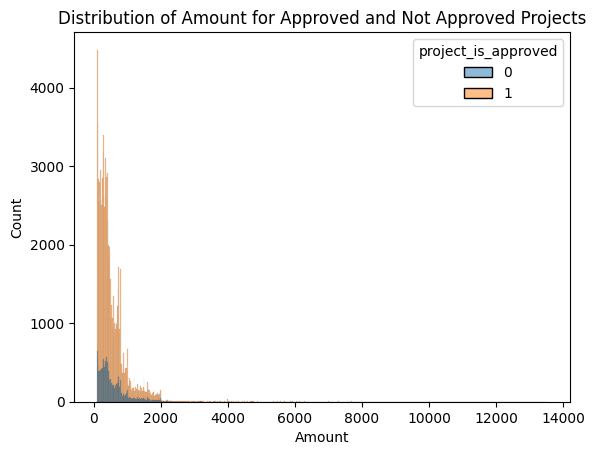

In [31]:
## Write code for additional analysis here
sns.histplot(data=project_data, x='amount', hue='project_is_approved')
plt.title('Distribution of Amount for Approved and Not Approved Projects')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.show()

# The data is skewed with a longer tail on right

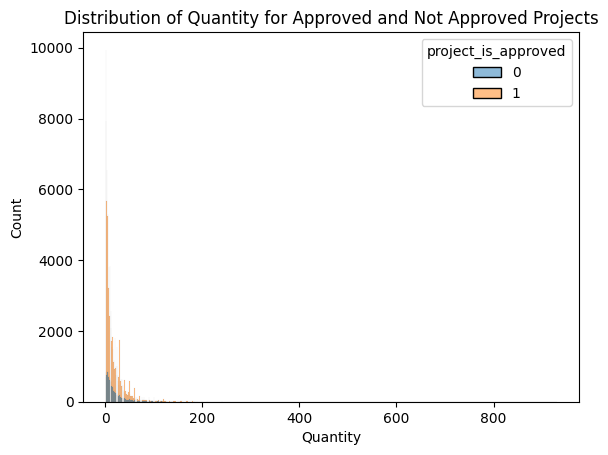

In [32]:
## Write code for additional analysis here
sns.histplot(data=project_data, x='quantity', hue='project_is_approved')
plt.title('Distribution of Quantity for Approved and Not Approved Projects')
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.show()

# Quantity is also right skewed

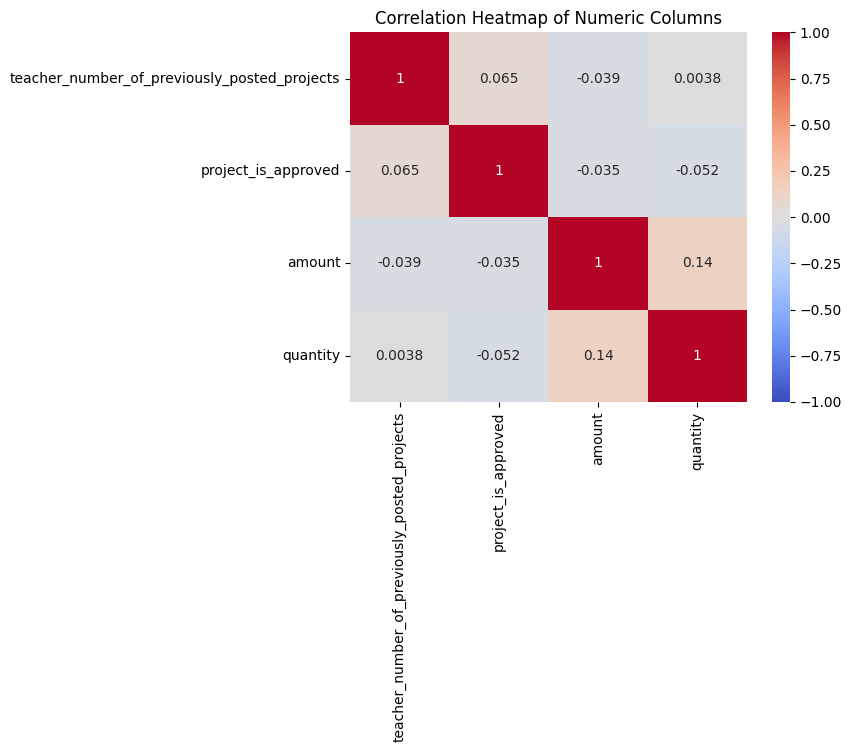

In [33]:
## Write code for additional analysis here

# Plot correlation plot using heatmap
numeric_data = project_data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

**Observations**

Document all the insights you get from EDA here

- The approval rate is between 80-90% for the categorical features. No categorical feature stands out as a strong predictor.
- With all features showing similar approval rates, it may be challenging to identify strong individual predictors for our model.
- The uniformity in approval rates suggests we may need to explore additional features or create derived features to improve our model's predictive power.
- There is a class imbalance between approved and not approved data. We'll use under sampling technique for the majority class (class 1 i.e. approved)
- Also, there is a tiny negative correlation between amount and project approval status. The approved projects costs about $30-50 less than the not approved ones (considering mean values). Similarly, even tinier negative correlation exists between approval status and quantity.
- Only noteworthy correlations to call out are between (amount & quanity) and (project approval & whether the teacher previously posted other projects). The latter is a weak correlation. So, likely the project approval odds improve when the teacher has previously posted other projects, some of which may have been approved (given 80-90% approval rate).

***Checklist***

Before proceeding further, check
- the overall approval rate is analyzed and visualized
- the approval rate is analyzed vs different other features both categorical and numeric
- if you created any new columns here for analysis, once again check the dataframe to inspect

In [34]:
## Write the code to perform any necessary sanity checks before proceeding further

# Completed above and summarized in above section

With this the EDA section is now complete. Now, let's proceed to the next section on preparing the data for model building later

## Pre-Modelling Data Preparation

There are 5 steps to be done before we proceed to model building

- Handle the class imbalance in the data
- Text Pre-Processing for raw text columns
- Feature Encoding (One-hot encoding, etc.) for categorical columns
- Scaling (Standardization, Normalization, etc.) for numeric columns
- train-test-validation split

**Handling Class Imbalance**

As per the target variable distribution seen earlier, the datapoints for class "0" (not approved) is much low when compared with class "1" (approved).
This may lead to the model learning more than "1" class as compared to "0" class. Also the number of records are huge - 100k. You can follow these steps:

  - **Undersampling**: Reduce the data imbalance by selecting all instances from the minority class (class "0") and randomly selecting an equal number of instances from the majority class (class "1").

  - **Oversampling**: Increase the representation of the minority class by techniques like Random Oversampling or SMOTE to balance the dataset.

Choosing the appropriate method is crucial. It depends on various factors and the specific requirements of your model.As the number of columns would increase significantly once we start using text processing, it is imperative to take a pragmatic decision here.

In [35]:
### Write the code for handling class imbalance here

from imblearn.under_sampling import RandomUnderSampler

# Separate X & target variable
X = project_data.drop('project_is_approved', axis=1)
y = project_data['project_is_approved']

# Apply undersampling of the majority class (approved records)
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Create a new dataframe with balanced class records
project_data_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns),
                           pd.Series(y_resampled, name='project_is_approved')], axis=1)

# Ensure both classes are now balanced
print(project_data_balanced['project_is_approved'].value_counts())

project_is_approved
0    16542
1    16542
Name: count, dtype: int64


In [36]:
### Inspect the new dataframe and see if it looks okay
print(project_data_balanced.shape)
project_data_balanced.head()

(33084, 15)


,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,amount,quantity,project_essay,project_is_approved
0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students need opportunities to practice beg...,0,596.36,23,My students are English learners that are work...,0
2,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"My students need shine guards, athletic socks,...",1,686.68,22,"\r\n\""True champions aren't always the ones th...",0
12,p051126,5e52c92b7e3c472aad247a239d345543,Mrs.,NY,2016-05-23 15:46:02,Grades 6-8,Math & Science,"Environmental Science, Health & Life Science",Building Life Science Experiences,My students need 3D and 4D life science activi...,5,274.87,22,My students are always working on new projects...,0
14,p233127,424819801de22a60bba7d0f4354d0258,Ms.,MA,2017-02-14 16:29:10,Grades PreK-2,Literacy & Language,Literacy,TABLETS CAN SHOW US THE WORLD,My students need 5 tablets for our classroom t...,15,459.70,10,My students are my babies...I want the world f...,0
22,p165540,30f08fbe02eba5453c4ce2e857e88eb4,Ms.,CA,2016-09-01 10:09:15,Grades 9-12,Literacy & Language,Literacy,Books for Budding Intellectuals,My students need books so that they can become...,0,278.09,21,"Every day in my English classroom, we work to ...",0


**Text-Processing**

There are two steps to be performed here

- Text Cleaning
- Conversion of text features to numeric features

***Text Cleaning***

Raw text often presents several challenges. Some of them include:

- **Noise and Irrelevant Information**: Raw text can include extraneous information that may not be useful for analysis or modeling.

- **Inconsistent Formatting**: Text data can vary in format, which makes it difficult to standardize and process.

- **Spelling and Grammar Errors**: Errors in spelling, grammar, and punctuation can affect the quality of text analysis and processing.

- **High Dimensionality**: Text data can be high-dimensional due to the large number of unique words or terms, complicating analysis and modeling.

- **Language Variability**: Variations in language usage, slang, or domain-specific terminology can impact the consistency and effectiveness of text analysis.


- Let's clean the text to improve the quality of data
  
  - Decontracting text, removing escape sequences, special characters and stop words

  - You can use two popular libraries to handle text data.
    1. Natural Language ToolKit (nltk)
    2. Regular Expressions (re)

To help you prepare your text for analysis, we have included some basic functions for cleaning and normalization. Use these functions as a starting point and tailor them to achieve optimal text quality.

In [37]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk

nltk.download('stopwords')
nltk.download('punkt')

# Decontracting text involves expanding contractions into their full forms.
def decontract_text(text):

    # decontract text

    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    return text

# Escape sequences are special character combinations used to represent characters that cannot be directly represented.
# These often need to be removed for text processing.

def remove_escape_sequences(text):

    # remove escape sequences

    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')

    return text


# Remove special characters using regular expressions.
# Special characters are characters that are not letters or numbers.
# These often include punctuation, symbols, and control characters.

def remove_special_characters(text):
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text


# Stop words are common words that often carry little semantic meaning (e.g., "the," "and," "is").
# Removing them can help focus on the more important words in the text.
def remove_stop_words(text):

        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
        #with no lower case conversion
        filtered_sentence = []
        for w in word_tokens:
                if w not in stop_words:
                        filtered_sentence.append(w)
        return filtered_sentence


def preprocess_text(text):

  text = decontract_text(text)
  text = remove_escape_sequences(text)
  text = remove_special_characters(text)
  text = remove_stop_words(text)

  text = ' '.join(text)

  return text.lower().strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [38]:
# Perform text cleaning steps on your text_columns
# Type your code here

# preprocess essays
preprocessed_essays = [preprocess_text(essay) for essay in project_data_balanced['project_essay'].values]
preprocessed_essays[:3]

['my students english learners working english second third languages we melting pot refugees immigrants native born americans bringing gift language school we 24 languages represented english learner program students every level mastery we also 40 countries represented families within school each student brings wealth knowledge experiences us open eyes new cultures beliefs respect the limits language limits world ludwig wittgenstein our english learner strong support system home begs resources many times parents learning read speak english along side children sometimes creates barriers parents able help child learn phonetics letter recognition reading skills by providing dvd players students able continue mastery english language even one home able assist all families students within level 1 proficiency status offered part program these educational videos specially chosen english learner teacher sent home regularly watch the videos help child develop early reading skills parents acces

In [39]:
# preprocess project titles
preprocessed_title = [preprocess_text(title) for title in project_data_balanced['project_title'].values]
preprocessed_title[:5]

['educational support english learners home',
 'soccer equipment awesome middle school students',
 'building life science experiences',
 'tablets can show us the world',
 'books budding intellectuals']

In [40]:
# preprocess resource summary
preprocessed_resource_summary = [preprocess_text(summary) for summary in project_data_balanced['project_resource_summary'].values]
preprocessed_resource_summary[:5]

['my students need opportunities practice beginning reading skills english home',
 'my students need shine guards athletic socks soccer balls goalie gloves training materials upcoming soccer season',
 'my students need 3d 4d life science activity kits get full effect lessons work groups store models sturdy bins',
 'my students need 5 tablets classroom technology center please',
 'my students need books become engaged motivated self directed readers']

In [41]:
# replace existing columns with preprocessed data
project_data_balanced['project_essay'] = preprocessed_essays
project_data_balanced['project_title'] = preprocessed_title
project_data_balanced['project_resource_summary'] = preprocessed_resource_summary

In [42]:
## Check the dataframe and see if the columns are cleaned or not
project_data_balanced.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,amount,quantity,project_essay,project_is_approved
0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",educational support english learners home,my students need opportunities practice beginn...,0,596.36,23,my students english learners working english s...,0
2,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",soccer equipment awesome middle school students,my students need shine guards athletic socks s...,1,686.68,22,true champions always ones win guts by mia ham...,0
12,p051126,5e52c92b7e3c472aad247a239d345543,Mrs.,NY,2016-05-23 15:46:02,Grades 6-8,Math & Science,"Environmental Science, Health & Life Science",building life science experiences,my students need 3d 4d life science activity k...,5,274.87,22,my students always working new projects time w...,0
14,p233127,424819801de22a60bba7d0f4354d0258,Ms.,MA,2017-02-14 16:29:10,Grades PreK-2,Literacy & Language,Literacy,tablets can show us the world,my students need 5 tablets classroom technolog...,15,459.70,10,my students babies i want world i teach three ...,0
22,p165540,30f08fbe02eba5453c4ce2e857e88eb4,Ms.,CA,2016-09-01 10:09:15,Grades 9-12,Literacy & Language,Literacy,books budding intellectuals,my students need books become engaged motivate...,0,278.09,21,every day english classroom work develop stude...,0


Feel free to exlore other Python libraries that can help you improve the text quality.

---

***Conversion of text features to numeric features***

- Machine Learning models can't work on plain English text. We need to convert this text into a structured format with numbers.

  - How can we turn text into numbers? This is where the Bag of Words method comes in. In BoW, each text feature (like a sentence or paragraph) is treated as a collection of words.
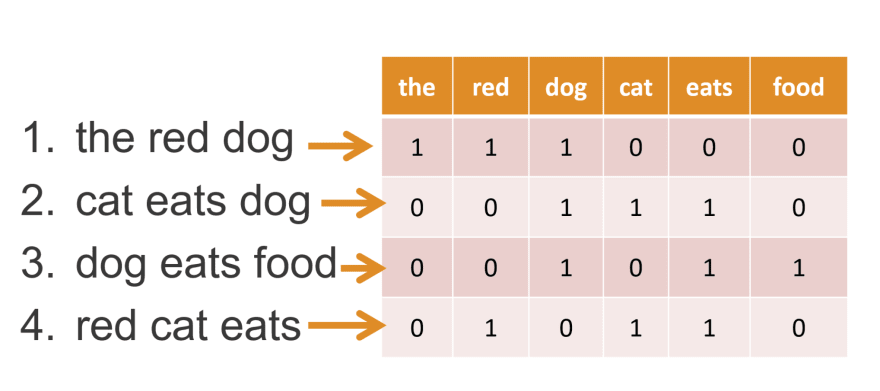

- **Creating the Vocabulary**:
  - The BoW model will first create a list of all unique words across all your text features.

- **Counting Word Frequencies**:
  - For each text feature, the BoW model counts the occurrences of each word from the vocabulary.

- **Building Feature Vectors**:
  - These word counts are then used to build feature vectors for each text feature, which can be used as input for your machine learning models.




## Train & Test split

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(project_data_balanced, project_data_balanced['project_is_approved'], test_size=0.3, random_state=42)

In [44]:
X_train['project_is_approved'].value_counts(), X_test['project_is_approved'].value_counts()

(project_is_approved
 1    11599
 0    11559
 Name: count, dtype: int64,
 project_is_approved
 0    4983
 1    4943
 Name: count, dtype: int64)

In [45]:
# Drop target column and non-relevant columns like ID values (those don't influence the model prediction)
X_train = X_train.drop(columns=['id', 'teacher_id', 'project_is_approved'])
X_test = X_test.drop(columns=['id', 'teacher_id', 'project_is_approved'])

In [46]:
## Steps to perform a bag of words model

# Import necessary library
# Use sklearn.feature_extraction.text for the CountVectorizer class.
# Your code here

from sklearn.feature_extraction.text import CountVectorizer

In [47]:
# Instantiate a CountVectorizer Object
# Your code here

# Function to vectorize a column
def vectorize_column(train_col, test_col, column_name):
    vectorizer = CountVectorizer()
    train_vectorized = vectorizer.fit_transform(train_col.astype(str))
    test_vectorized = vectorizer.transform(test_col.astype(str))

    train_df = pd.DataFrame(train_vectorized.toarray(), columns=[f"{column_name}_{feat}" for feat in vectorizer.get_feature_names_out()])
    test_df = pd.DataFrame(test_vectorized.toarray(), columns=[f"{column_name}_{feat}" for feat in vectorizer.get_feature_names_out()])

    return train_df, test_df

In [48]:
# Use the fit_transform method on your text data.
# This creates a document-term matrix where rows represent documents and columns represent words.
# Your code here

# List of features for feature extraction
features = ['teacher_prefix', 'school_state', 'project_grade_category', 'project_subject_categories', 'project_subject_subcategories']

# Vectorize each feature
X_train_encoded = pd.DataFrame()
X_test_encoded = pd.DataFrame()

for feature in features:
    train_vectorized, test_vectorized = vectorize_column(X_train[feature], X_test[feature], feature)
    X_train_encoded = pd.concat([X_train_encoded, train_vectorized], axis=1)
    X_test_encoded = pd.concat([X_test_encoded, test_vectorized], axis=1)

In [49]:
# Examine the Output
# The output is a sparse matrix. You can convert it to a dense matrix or DataFrame for easier manipulation.
# Your code here

# Now X_train_encoded and X_test_encoded contain the vectorized features
print("Shape of encoded training data:", X_train_encoded.shape)
print("Shape of encoded test data:", X_test_encoded.shape)
X_train_encoded.head()

Shape of encoded training data: (23158, 125)
Shape of encoded test data: (9926, 125)


,teacher_prefix_dr,teacher_prefix_mr,teacher_prefix_mrs,teacher_prefix_ms,teacher_prefix_teacher,school_state_ak,school_state_al,school_state_ar,school_state_az,school_state_ca,...,project_subject_subcategories_sciences,project_subject_subcategories_service,project_subject_subcategories_social,project_subject_subcategories_special,project_subject_subcategories_sports,project_subject_subcategories_team,project_subject_subcategories_visual,project_subject_subcategories_warmth,project_subject_subcategories_wellness,project_subject_subcategories_writing
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF for feature extraction

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to combine text features
def combine_text_features(df):
    return df['project_essay'] + ' ' + df['project_title'] + ' ' + df['project_resource_summary']

# Combine text features for both train and test sets
X_train_text = combine_text_features(X_train)
X_test_text = combine_text_features(X_test)

In [51]:
# Initialize TfidfVectorizer

# Use min doc freq of 10 to eliminate rare terms
# Limit max to 5,000 columns as Google Collab crashes for 10,000 features when DFs are concatenated later
tfidf_vectorizer = TfidfVectorizer(min_df=10, max_features=5000)

# Fit on training data and transform both training and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

# Convert to DataFrames if needed
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [52]:
print(X_train_tfidf_df.shape, X_test_tfidf_df.shape)
X_train_tfidf_df.head()

(23158, 5000) (9926, 5000)


,00,000,10,100,1000,10th,11,110,11th,12,...,younger,youngest,your,youth,youtube,zero,zip,zone,zones,zoo
0,0.0,0.0,0.0,0.050095,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.094065,0.0,0.0,0.081761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# The TF-IDF creates "amount" column from text. There is already an "amount" column (price * quantity).
# We need to rename TF-IDF amount to prevent duplicate column names. Duplicate columns cause problems with XGBoost later during model training.
print(X_train_tfidf_df['amount'].value_counts())
X_train_tfidf_df = X_train_tfidf_df.rename(columns={'amount': 'amount_tfidf'})

amount
0.000000    22327
0.146771        1
0.074337        1
0.092224        1
0.078173        1
            ...  
0.096960        1
0.082183        1
0.063068        1
0.089876        1
0.075227        1
Name: count, Length: 832, dtype: int64


In [54]:
# Also rename "amount" to "amount_tfidf" in test
print(X_test_tfidf_df['amount'].value_counts())
X_test_tfidf_df = X_test_tfidf_df.rename(columns={'amount': 'amount_tfidf'})

amount
0.000000    9578
0.065606       1
0.067723       1
0.067665       1
0.050017       1
            ... 
0.086105       1
0.081572       1
0.083644       1
0.080732       1
0.073251       1
Name: count, Length: 349, dtype: int64


In [55]:
# [Optional] You can consider applying PCA on the obtained matrix (or DataFrame).
# Select the top-k dimensions that preserve ~[95% or more] variance.
# This can save time in model training.
# Your code here.

Once you have performed the necessary steps, it's time to move to the feature encoding part

**Feature Encoding (One-hot encoding, etc.) for categorical columns**

In [56]:
## Write code for performing one-hot encoding and other encoding for categorical columns

# The categorical values have been encoded using CountVectorizer into numeric values
# The text data has been encoded using TF-IDF. We can skip One-Hot encoding.

Once you have performed the necessary steps, it's time to move to feature scaling part

**Scaling (Standardization, Normalization, etc.) for numeric columns**
- Before the ML modelling part, ensure all the numeric features are scaled properly

In [57]:
# Check the numeric features needing scaling
print('teacher_number_of_previously_posted_projects (min, max):', (X_train['teacher_number_of_previously_posted_projects'].min(), X_train['teacher_number_of_previously_posted_projects'].max()))
print('amounts (min, max):', (X_train['amount'].min(), X_train['amount'].max()))
print('quantity (min, max):',(X_train['quantity'].min(), X_train['quantity'].max()))

# The above features can be scaled to bring the values between 0-1 due to the wide variance in some of the values

teacher_number_of_previously_posted_projects (min, max): (0, 451)
amounts (min, max): (100.0, 12344.0)
quantity (min, max): (1, 808)


In [58]:
## Write the code for scaling the numeric features of the dataset

from sklearn.preprocessing import StandardScaler

# Assuming 'columns_to_scale' is a list of column names you want to scale
columns_to_scale = ['teacher_number_of_previously_posted_projects', 'amount', 'quantity']  # Replace with your actual column names

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the specified columns for X_train & X_test
X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled = scaler.transform(X_test[columns_to_scale])

# Convert the scaled data to DataFrames, including only the scaled columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=columns_to_scale)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=columns_to_scale)

In [59]:
print(X_train_scaled_df.shape)
X_train_scaled_df.head()

(23158, 3)


,teacher_number_of_previously_posted_projects,amount,quantity
0,0.148849,0.357247,0.094265
1,-0.344403,-0.484492,-0.337142
2,0.806520,0.306241,3.725275
3,-0.385508,0.263963,-0.480944
4,-0.385508,-0.621700,-0.337142


Once you have performed the necessary steps, let's combine all the features to create the X and y variables

**train-test-validation split**

In [60]:
# Concatenate all the final features [BoW, numeric, and one-hot encoded categorical features] as your input X
# X =
# y =  # the target column: "project_is_approved"

print('X_train_encoded.shape:', X_train_encoded.shape)
print('X_train_tfidf_df.shape:', X_train_tfidf_df.shape)
print('X_train_scaled_df.shape:', X_train_scaled_df.shape)

# Concatenate all the preprocessed + scaled features into the final X_train
X_train_processed = pd.concat([X_train_encoded, X_train_tfidf_df, X_train_scaled_df], axis=1)
X_train_processed.shape

X_train_encoded.shape: (23158, 125)
X_train_tfidf_df.shape: (23158, 5000)
X_train_scaled_df.shape: (23158, 3)


(23158, 5128)

In [61]:
# Concatenate the preprocess & scaled features into X_test
print('X_test_encoded.shape:', X_test_encoded.shape)
print('X_test_tfidf_df.shape:', X_test_tfidf_df.shape)
print('X_test_scaled_df.shape:', X_test_scaled_df.shape)

preprocessed_test_dfs = [X_test_encoded, X_test_tfidf_df, X_test_scaled_df]
X_test_processed = pd.concat(preprocessed_test_dfs, axis=1)
X_test_processed.shape

X_test_encoded.shape: (9926, 125)
X_test_tfidf_df.shape: (9926, 5000)
X_test_scaled_df.shape: (9926, 3)


(9926, 5128)

In [62]:
X_train_processed.shape

(23158, 5128)

Let's split the combined dataframe into the following partitions: `train`, `validation`, and `test`.

In [65]:
## Write the code to split the dataset here
## Chose around 60-80% as training 10-20% test and 10-20% validation

# After preprocessing is done, verify the shape is consistent
print(X_train_processed.shape)
print(X_test_processed.shape)
print(y_train.shape)
print(y_test.shape)

(23158, 5128)
(9926, 5128)
(23158,)
(9926,)


Once the train-test-validation split is done, it's time to move on to the model building part

## Model Building

#### Very Important

Ensure that you have only taken a sample of the entire dataset for building the first few models. Or else the number of columns and rows would be too huge for you to run and it may take hours to train.

- Start off with 20% of the original dataset.
- Perform the model building and evaluation steps on the same.
- Once you have obtained decent results, document those and then scale the datapoints based on the results that you're getting.


Note - Model Building and Model Evaluation sometimes happen together for identifying the best models. Hence then next two sections can be considered as a single large section and you can complete them together

Your goal is to build a classification model that is able to identify which projects get approved. For this, build at least 2 classifcation models to compare and contrast

### Basic Logistic Regression model (Model# 1)

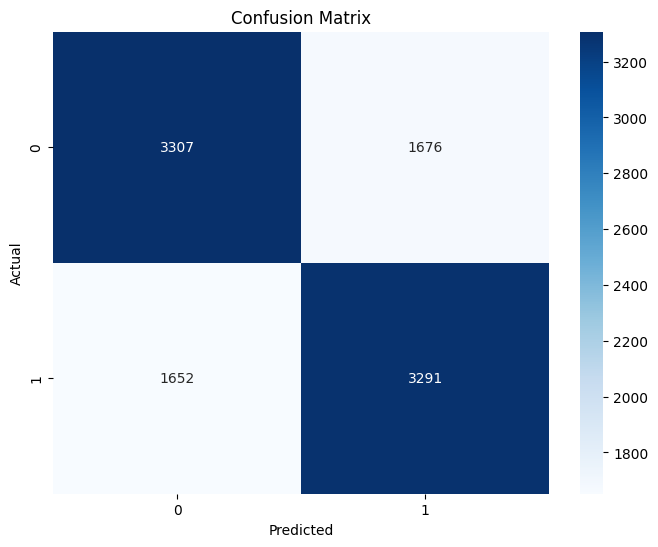

              precision    recall  f1-score   support

           0       0.67      0.66      0.67      4983
           1       0.66      0.67      0.66      4943

    accuracy                           0.66      9926
   macro avg       0.66      0.66      0.66      9926
weighted avg       0.66      0.66      0.66      9926



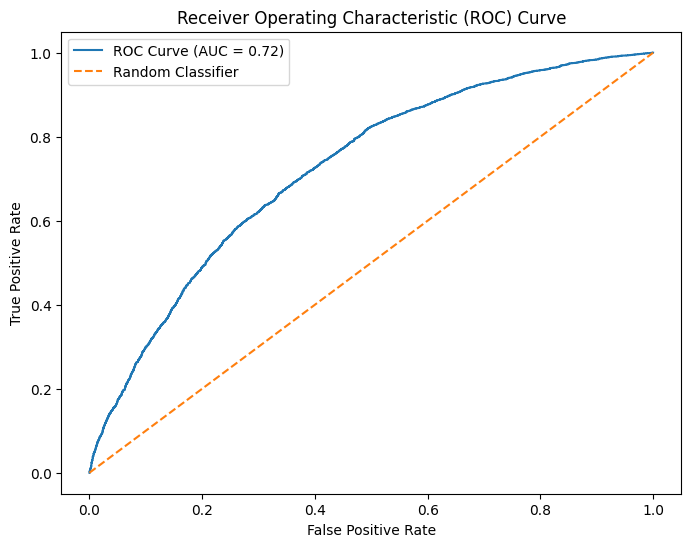

Cross-validation scores: [0.66234888 0.65803109 0.65911054 0.6462967  0.66033254]
Mean CV score: 0.657 (+/- 0.011)


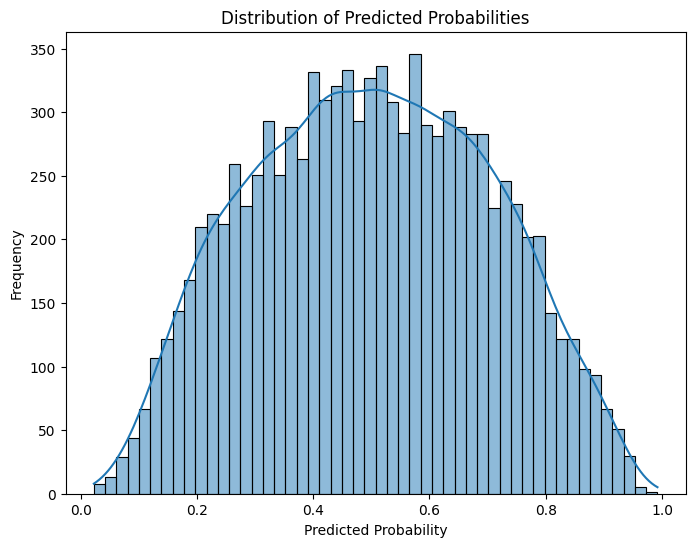

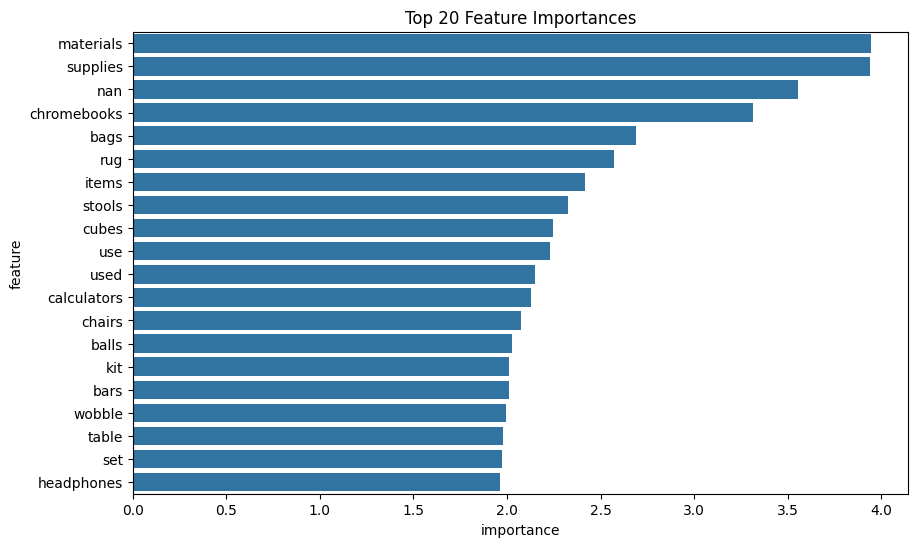

In [64]:
# Choose an appropriate machine learning model for classification.
# You can start with logistic regression.
# Your code here

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train the model
model = LogisticRegression(max_iter=400, random_state=42)
model.fit(X_train_processed, y_train)

# Make predictions
y_pred = model.predict(X_test_processed)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Cross-validation
cv_scores = cross_val_score(model, X_train_processed, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Predicted Probabilities Distribution
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba, kde=True, bins=50)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

# Feature Importance (for interpretability)
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

### Logistic Regression with RandomizedSearchCV (Model# 2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters found:  {'C': 3.4801873377804284, 'max_iter': 100, 'solver': 'sag'}
Best cross-validation score (AUC):  0.7158320526788696


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross-validation scores (AUC): [0.71779024 0.7240669  0.71989694 0.71000836 0.72301665]
Mean CV score (AUC): 0.719 (+/- 0.010)
AUC score on test set: 0.7275357701111961


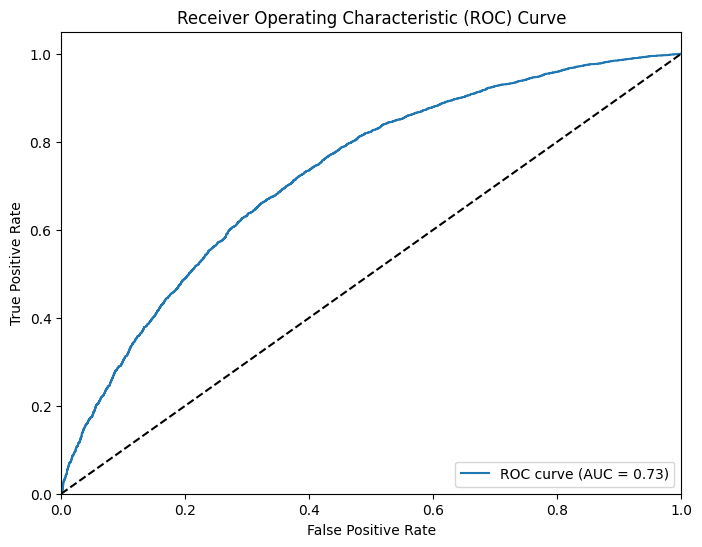

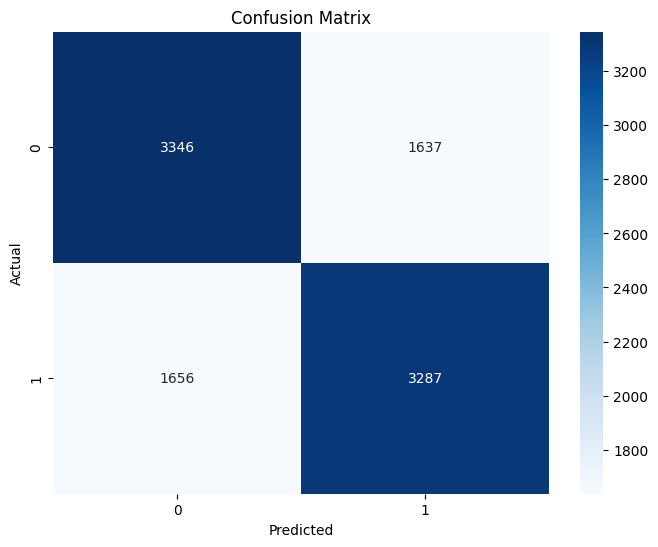

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      4983
           1       0.67      0.66      0.67      4943

    accuracy                           0.67      9926
   macro avg       0.67      0.67      0.67      9926
weighted avg       0.67      0.67      0.67      9926



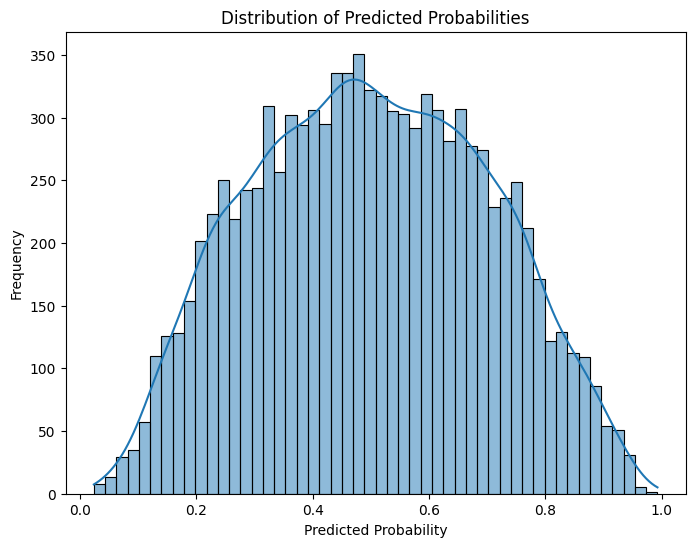

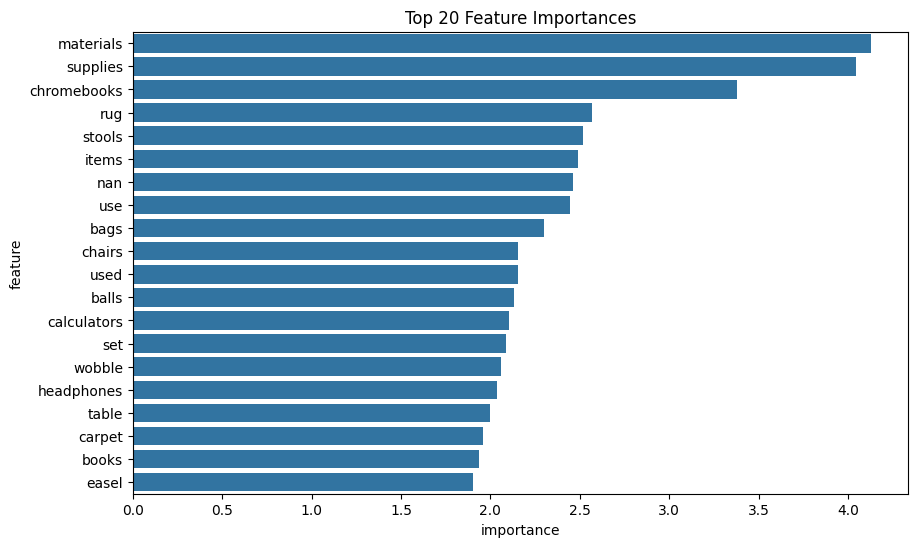

In [65]:
# Hyperparameter Tuning
# Use GridSearchCV or RandomizedSearchCV (better-suited here) to find the best hyperparameters for the chosen model.
# Your code here.

# !!! Please be aware that this model takes a lot of time (minutes to hour) to train. !!!
# Best parameters found:  {'C': 3.4801873377804284, 'max_iter': 100, 'solver': 'sag'}

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from scipy.stats import uniform, loguniform
import matplotlib.pyplot as plt
import seaborn as sns

# Create a LogisticRegression instance with L2 penalty
log_reg = LogisticRegression(penalty='l2', random_state=42)

# Define the parameter distributions
param_dist = {
    'C': loguniform(1e-4, 1e4),
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'max_iter': [100, 500, 1000]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings that are sampled
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42,
    scoring='roc_auc'  # Use AUC as the scoring metric
)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train_processed, y_train)

# Print the best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score (AUC): ", random_search.best_score_)

# Get the best model
best_model = random_search.best_estimator_

# Perform cross-validation on the best model
cv_scores = cross_val_score(best_model, X_train_processed, y_train, cv=5, scoring='roc_auc')
print("Cross-validation scores (AUC):", cv_scores)
print("Mean CV score (AUC): {:.3f} (+/- {:.3f})".format(cv_scores.mean(), cv_scores.std() * 2))

# Make predictions on the test set
y_pred = best_model.predict(X_test_processed)
y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC score on test set:", auc_score)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot predicted probabilities distribution
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba, kde=True, bins=50)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

# Feature importance (for interpretability)
if hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': X_train_processed.columns,
        'importance': abs(best_model.coef_[0])
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title('Top 20 Feature Importances')
    plt.show()

### Logistic Regression vs XGBoost (Model# 3)

AUC: 0.724
Cross-validation AUC: 0.715 (+/- 0.010)

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67      4983
           1       0.66      0.67      0.66      4943

    accuracy                           0.66      9926
   macro avg       0.66      0.66      0.66      9926
weighted avg       0.66      0.66      0.66      9926

AUC: 0.725
Cross-validation AUC: 0.709 (+/- 0.012)

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      4983
           1       0.67      0.66      0.67      4943

    accuracy                           0.67      9926
   macro avg       0.67      0.67      0.67      9926
weighted avg       0.67      0.67      0.67      9926



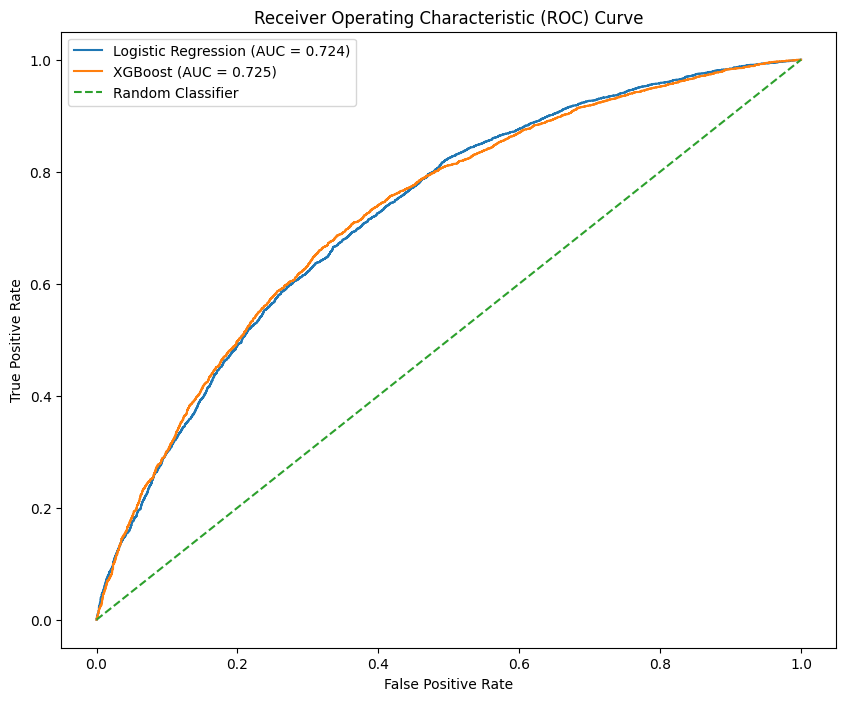

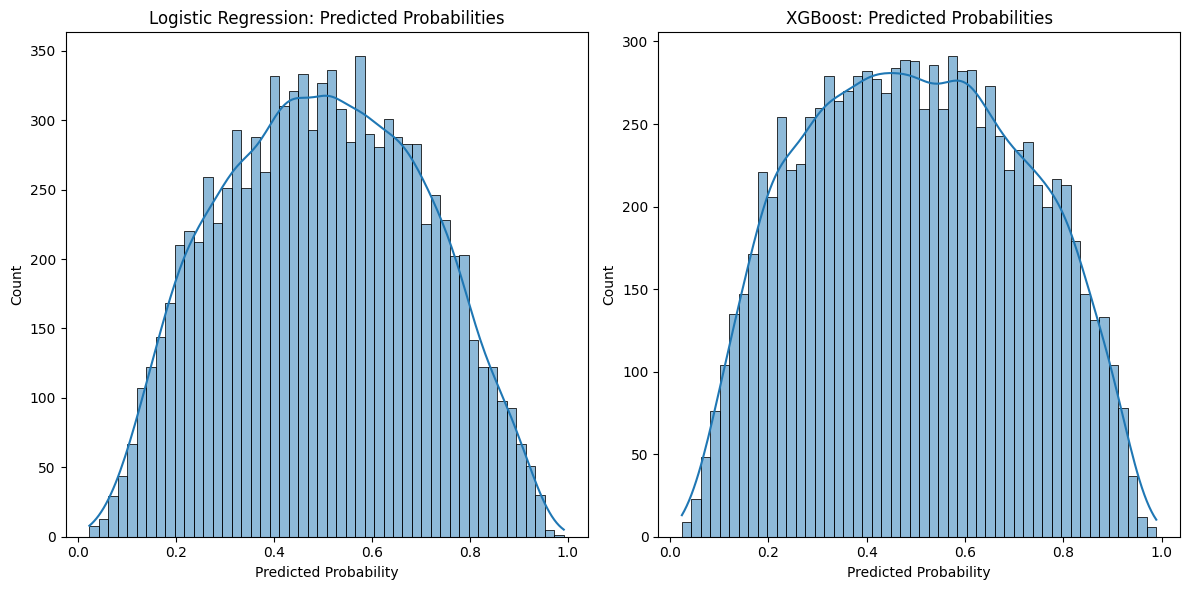

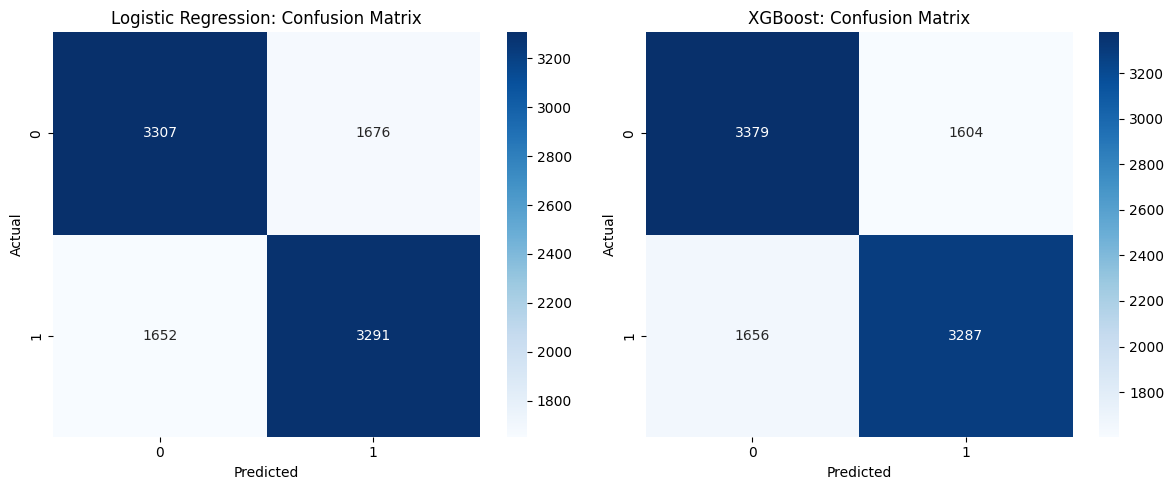

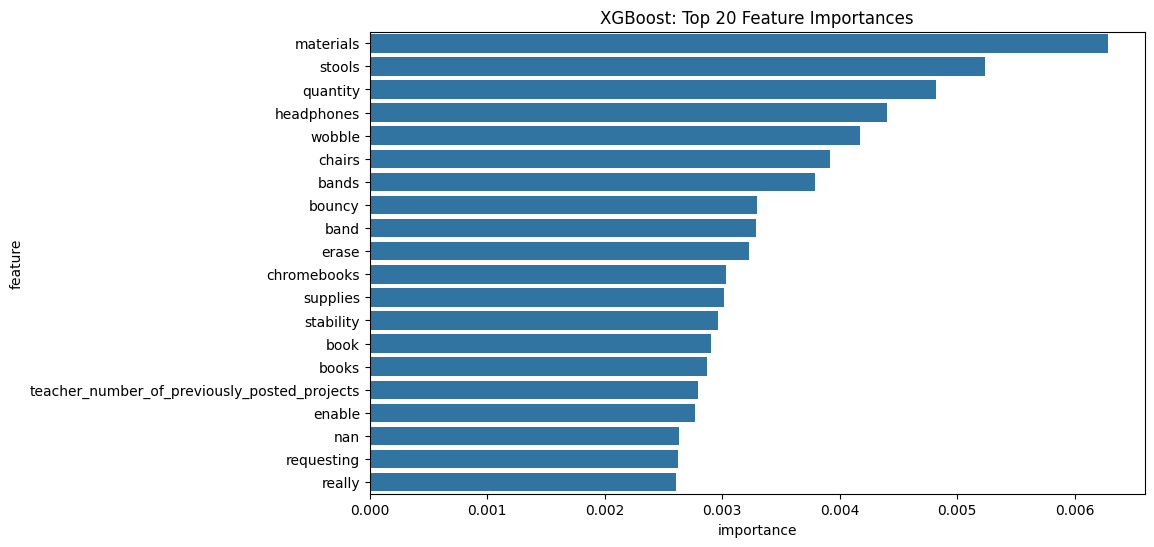

In [68]:
## Choose another model and similar to above, perform the hyperparameter tuning for the same

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from xgboost import XGBClassifier

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Compute AUC
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC: {auc:.3f}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"Cross-validation AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return fpr, tpr, auc, y_pred_proba, cm

# Create and evaluate Logistic Regression model
lr_model = LogisticRegression(max_iter=400, random_state=42)
lr_fpr, lr_tpr, lr_auc, lr_pred_proba, lr_cm = evaluate_model(lr_model, X_train_processed, X_test_processed, y_train, y_test)

# Create and evaluate XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_processed, y_train)
xgb_fpr, xgb_tpr, xgb_auc, xgb_pred_proba, xgb_cm = evaluate_model(xgb_model, X_train_processed, X_test_processed, y_train, y_test)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.3f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot predicted probabilities distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(lr_pred_proba, kde=True, bins=50)
plt.title('Logistic Regression: Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.subplot(1, 2, 2)
sns.histplot(xgb_pred_proba, kde=True, bins=50)
plt.title('XGBoost: Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.tight_layout()
plt.show()

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Logistic Regression: Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('XGBoost: Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature importance for XGBoost
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('XGBoost: Top 20 Feature Importances')
plt.show()

## Model Evaluation

Evaluate the above models based on the various evaluation metrics like accuracy, precision, recall, F1-score, etc.

**Observations**

*Document your observations regarding the different models that you have built, and their evaluation metrics*

- Evaluation Summary is provided below for all 3 models.

## Summary

Good work completing all the steps till now!

Now, go ahead and summarize your entire work and findings below:

- I trained 3 models with the given dataset and evaluated the efficiency of each.

1.   **Base Logistic Regression Model**
2.   **Logistic Regression Model with RandomizedSearchCV**
3.   **XGBoost Model**

- The precision, recall and F1-score for all the 3 models is roughly around 0.66. It's slightly better at 0.67 with the 2nd & 3rd model.
- AUC value for all the 3 models is around 0.725
- The number of false positives are about the same with all the 3 models with little variations.
- The test accuracy is around 67%, which isn't very high but an reasonably acceptable number.
- I compared a base LR model with XGBoost side by side and the difference isn't very noticeable between the tewo for the type of data we're processing.
- My observation is that the base LR model trained the quickest. The 2nd model took considerably longer to train. The 3rd model took about 10 min.
- The future improvements might include applying Decision Tree techniques to measure the model efficiencies.
- In addition, advanced industry techniques (if any) can be applied for encoding the text data to see if it improves the model accuracy and efficiency.

---

### **Some Python libraries that are worth exploring for similar projects**
  - **tqdm**: A Python library used to create progress bars for iterables. It provides visual feedback on the progress of long-running operations, making it easier to track the execution time and estimate the remaining time.
  - **Low-code learning libraries** Use lazypredict or PyCaret to compare the performance of multiple Machine Learning models simultaneously. *The best part is that you only need to write fewer than 10 lines of code.*
  - **Explainable AI**: Understand model decisions through techniques like LIME or SHAP.

---



### **Future Improvements**
- **[Optional: Bayesian Optimization]** Leverage Optuna or hyperopt or scikit-optimize for hyperparameter optimization.
- **[Optional: Imbalanced Classification]** Use imbalanced-learn (*imblearn*) for handling skewed datasets. You can try class weighting.
- **[Optional: NLP Concepts]** If you have time, consider exploring concepts like Term Frequency Inverse Document Frequency (TF-IDF), Stemming, Lemmatization, and Text (Document/Paragraph/Sentence) Embeddings. These topics will be covered in the upcoming Natural Language Processing (NLP) modules.




---

